In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer , Flatten
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [36]:
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [37]:
btc_data = df_btc.values[:, 4 ,].astype(float)

<Strong> Scaling the data  </Strong>

In [38]:
percTrain = 70
percVal = 20 

In [39]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Hyper-parameters </Strong>

In [40]:
# Hyper Parameters 

# How many hidden layers we should have 
# Learning rate
# Kernel Size
# Window Size
#Filters

window_length = 24
features = 1

<Strong> Creating Matrix in Sliding window form <Strong>

In [41]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [42]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

<Strong> Window length 24  </Strong>

In [31]:
model = models.Sequential()

model.add(Conv1D(filters= 16, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))

model.add(Conv1D(filters= 16, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=3))

model.add(Conv1D(filters= 16 , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=9))

model.add(Flatten())

model.add(Dense(16, activation='relu'))

model.add(Dense(1))

model.summary()

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt , loss = 'mse')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 24, 16)            64        
                                                                 
 conv1d_7 (Conv1D)           (None, 24, 16)            784       
                                                                 
 conv1d_8 (Conv1D)           (None, 24, 16)            784       
                                                                 
 flatten_2 (Flatten)         (None, 384)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                6160      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,809
Trainable params: 7,809
Non-traina

In [32]:

earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =500 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/500
54/54 [==============================] - 1s 9ms/step - loss: 0.0247 - val_loss: 0.0930
Epoch 2/500
54/54 [==============================] - 0s 4ms/step - loss: 5.0066e-04 - val_loss: 0.0123
Epoch 3/500
54/54 [==============================] - 0s 4ms/step - loss: 3.0588e-04 - val_loss: 0.0137
Epoch 4/500
54/54 [==============================] - 0s 4ms/step - loss: 2.9665e-04 - val_loss: 0.0124
Epoch 5/500
54/54 [==============================] - 0s 4ms/step - loss: 2.8159e-04 - val_loss: 0.0119
Epoch 6/500
54/54 [==============================] - 0s 4ms/step - loss: 2.7007e-04 - val_loss: 0.0114
Epoch 7/500
54/54 [==============================] - 0s 4ms/step - loss: 2.5732e-04 - val_loss: 0.0105
Epoch 8/500
54/54 [==============================] - 0s 4ms/step - loss: 2.4513e-04 - val_loss: 0.0091
Epoch 9/500
54/54 [==============================] - 0s 4ms/step - loss: 2.3202e-04 - val_loss: 0.0078
Epoch 10/500
54/54 [==============================] - 0s 4ms/step - loss: 2.0

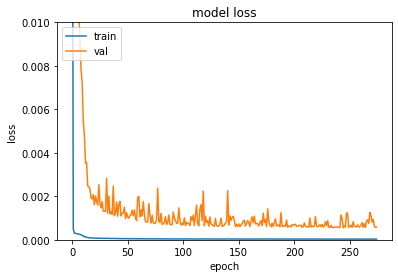

In [34]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.01])
plt.show()